<a href="https://colab.research.google.com/github/Jo9gi/LANE_DETECTION_TM17/blob/main/P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road**
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below.

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p>
 </figcaption>
</figure>
 <p></p>
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p>
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [51]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


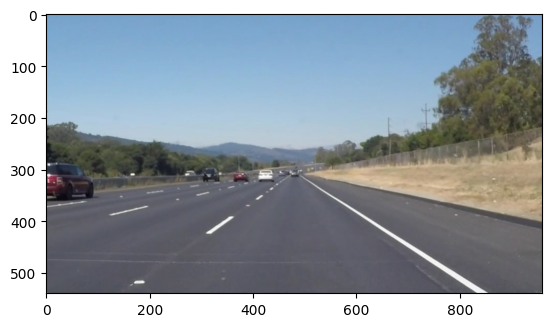

In [52]:
#reading in an image
image = mpimg.imread('/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [53]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [54]:
import os
os.listdir("/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [55]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the function to process an image
def process_image(image):
    """
    Detects lane lines in an image and overlays them.

    Parameters:
    - image: Input image (BGR format)

    Returns:
    - result: Image with lane lines drawn
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blur, 50, 150)

    # Define a mask for Region of Interest (ROI)
    height, width = image.shape[:2]
    mask = np.zeros_like(edges)
    polygon = np.array([[
        (50, height),  # Bottom-left
        (width // 2 - 50, height // 2 + 50),  # Top-left
        (width // 2 + 50, height // 2 + 50),  # Top-right
        (width - 50, height)  # Bottom-right
    ]], dtype=np.int32)

    cv2.fillPoly(mask, polygon, 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(masked_edges, rho=2, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)

    # Create a blank image to draw lines
    line_image = np.zeros_like(image)

    # Draw detected lane lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

    # Overlay the lane lines on the original image
    result = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    return result

# Directories
input_dir = "/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_images"
output_dir = "test_images_output"

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process all images in the test_images folder
for image_file in os.listdir(input_dir):
    if image_file.endswith((".jpg", ".png", ".jpeg")):  # Process only image files
        # Read the image
        img_path = os.path.join(input_dir, image_file)
        image = cv2.imread(img_path)

        # Process the image
        processed_image = process_image(image)

        # Save the result
        output_path = os.path.join(output_dir, image_file)
        cv2.imwrite(output_path, processed_image)
        print(f"Processed and saved: {output_path}")

print("✅ Lane detection completed. Check 'test_images_output' for results.")


Processed and saved: test_images_output/solidWhiteCurve.jpg
Processed and saved: test_images_output/solidWhiteRight.jpg
Processed and saved: test_images_output/solidYellowCurve.jpg
Processed and saved: test_images_output/solidYellowCurve2.jpg
Processed and saved: test_images_output/solidYellowLeft.jpg
Processed and saved: test_images_output/whiteCarLaneSwitch.jpg
✅ Lane detection completed. Check 'test_images_output' for results.


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe.
You can download it by calling:
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [81]:
def process_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny
    edges = cv2.Canny(blur, 50, 150)

    # Define a region of interest (ROI) mask
    mask = np.zeros_like(edges)
    height, width = edges.shape
    polygon = np.array([[
        (0, height),
        (width, height),
        (width, height // 2),
        (0, height // 2),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)

    # Mask the edges image
    masked_edges = cv2.bitwise_and(edges, mask)

    # Perform Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=50)

    # Create an image to draw the lines on
    line_image = np.zeros_like(image)

    # Draw the lines on the image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

    # Combine the original image with the line image
    result = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    return result

Let's try the one with the solid white lane on the right first ...

In [85]:
!pip install moviepy

In [86]:
import os
os.listdir("/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos")  # Check if the file exists


['challenge.mp4', 'solidWhiteRight.mp4', 'solidYellowLeft.mp4']

In [87]:
clip1 = VideoFileClip("/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos/solidWhiteRight.mp4")


In [88]:
clip1 = VideoFileClip("/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos/solidWhiteRight.mp4").subclip(0, 5)

clip1

In [89]:
white_output = "/content/solidWhiteRight_output.mp4"
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video /content/solidWhiteRight_output.mp4.
Moviepy - Writing video /content/solidWhiteRight_output.mp4



Moviepy - Done !
Moviepy - video ready /content/solidWhiteRight_output.mp4
CPU times: user 2.15 s, sys: 254 ms, total: 2.4 s
Wall time: 13.3 s


In [90]:
from google.colab import files
files.download("solidWhiteRight_output.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [98]:
from IPython.display import HTML
import base64

def show_video(video_path):
    mp4 = open(video_path, "rb").read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    return HTML(f"""
    <video width="960" height="540" controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """)

# Show the processed video
show_video("/content/solidWhiteRight_output.mp4")


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [94]:
import numpy as np
import cv2

def draw_lines(img, lines, color=(255, 0, 0), thickness=10):
    """
    Draws lane lines by averaging and extrapolating Hough line segments.

    Parameters:
    - img: The input image.
    - lines: Detected Hough line segments.
    - color: The color of the lane lines.
    - thickness: The thickness of the drawn lines.
    """

    left_lines = []  # (slope, intercept)
    right_lines = [] # (slope, intercept)

    left_weights = []  # Line segment lengths (to weight averaging)
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1) if x2 - x1 != 0 else 0  # Avoid division by zero

            if abs(slope) < 0.5:  # Ignore nearly horizontal lines
                continue

            intercept = y1 - (slope * x1)  # y = mx + b -> b = y - mx
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  # Line segment length

            if slope < 0:  # Negative slope → left lane
                left_lines.append((slope, intercept))
                left_weights.append(length)
            else:  # Positive slope → right lane
                right_lines.append((slope, intercept))
                right_weights.append(length)

    def average_slope_intercept(lines, weights):
        """Computes the weighted average of slopes and intercepts."""
        if len(lines) > 0:
            avg_slope = np.dot(weights, [l[0] for l in lines]) / np.sum(weights)
            avg_intercept = np.dot(weights, [l[1] for l in lines]) / np.sum(weights)
            return avg_slope, avg_intercept
        else:
            return None

    left_lane = average_slope_intercept(left_lines, left_weights)
    right_lane = average_slope_intercept(right_lines, right_weights)

    y1 = img.shape[0]  # Bottom of the image
    y2 = int(y1 * 0.6)  # Approximate where lane lines should end

    def make_line_coordinates(slope, intercept):
        """Generates line endpoints given slope & intercept."""
        if slope is None:
            return None
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)
        return (x1, y1, x2, y2)

    left_line = make_line_coordinates(*left_lane) if left_lane else None
    right_line = make_line_coordinates(*right_lane) if right_lane else None

    if left_line:
        cv2.line(img, (left_line[0], left_line[1]), (left_line[2], left_line[3]), color, thickness)
    if right_line:
        cv2.line(img, (right_line[0], right_line[1]), (right_line[2], right_line[3]), color, thickness)


In [95]:
import os
from moviepy.editor import VideoFileClip

# Ensure output directory exists
output_dir = "test_videos_output"
os.makedirs(output_dir, exist_ok=True)

# Define output file path
yellow_output = os.path.join(output_dir, "solidYellowLeft.mp4")

# Load the video
clip2 = VideoFileClip("/content/drive/MyDrive/project_folder/CarND-LaneLines-P1/test_videos/solidYellowLeft.mp4")

# Process each frame with the pipeline function
yellow_clip = clip2.fl_image(process_image)

# Save the processed video
%time yellow_clip.write_videofile(yellow_output, audio=False)


Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 13.1 s, sys: 1.46 s, total: 14.5 s
Wall time: 46.9 s


In [97]:
from IPython.display import HTML
import base64

def show_video(video_path):
    """Encodes video as base64 and embeds it in an HTML video tag."""
    mp4 = open(video_path, "rb").read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    return HTML(f"""
    <video width="960" height="540" controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """)

# Show processed video
show_video("test_videos_output/solidYellowLeft.mp4")


## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
